In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('train - train.csv')
df.head()

,ID,Order Date,Class,Region,Sub-Category,Sales
0,646,30/12/2018,Стандарт,Урал,Appliances,"37229,08"
1,907,30/12/2018,Стандарт,Владивосток,Bookcases,"20994,61"
2,908,30/12/2018,Стандарт,Владивосток,Phones,"42133,86"
3,909,30/12/2018,Стандарт,Владивосток,Binders,10612
4,1297,30/12/2018,Стандарт,Калиниград,Binders,"28781,13"


## Проведём EDA

In [3]:
df.shape

(9800, 6)

In [4]:
df.dtypes

ID               int64
Order Date      object
Class           object
Region          object
Sub-Category    object
Sales           object
dtype: object

### Можно заметить, что все типы данных, кроме ID - object

In [5]:
df['Order Date'] = pd.to_datetime(df['Order Date'], format="%d/%m/%Y")

In [6]:
df['Sales'] = df['Sales'].str.replace(',', '.', regex=False)

In [7]:
df['Sales'] = pd.to_numeric(df['Sales'])

In [8]:
df[['Class', 'Region', 'Sub-Category']] = df[['Class', 'Region', 'Sub-Category']].apply(lambda x: x.astype(str))

In [9]:
df['Sales'].describe()

count     9800.000000
mean     22921.757737
std      12601.999815
min       1002.794000
25%      12135.625000
50%      22882.060000
75%      33730.130000
max      44995.410000
Name: Sales, dtype: float64

### При среднем значении 22921, минимальное - 1002. Возможно это выброс

In [10]:
df['Class'].value_counts()

Стандарт        5859
Второй класс    1902
Первый класс    1501
Same Day         538
Name: Class, dtype: int64

In [11]:
df['Region'].value_counts()

Калиниград     3140
Владивосток    2785
Урал           2277
Москва         1598
Name: Region, dtype: int64

### Уберём пробел и дефис из названий столбцов

In [12]:
df.rename(columns={'Order Date': 'Order_Date', 'Sub-Category': 'Sub_Category'}, inplace=True)

In [13]:
df.isna().sum()

ID              0
Order_Date      0
Class           0
Region          0
Sub_Category    0
Sales           0
dtype: int64

# Какие подгруппы товаров наиболее часто покупают за все время продаж (минимум 4 группы)?

In [14]:
df['Sub_Category'].value_counts().head(4)

Binders        1492
Paper          1338
Furnishings     931
Phones          876
Name: Sub_Category, dtype: int64

# Какие подгруппы товаров наиболее часто покупают за последние два года?

### Определим самую последнюю дату в датасете

In [15]:
df['Order_Date'].max()

Timestamp('2018-12-30 00:00:00')

### Воспользуемся DateOffSet, чтобы вычесть n-ное кол-во лет

In [16]:
last2_years = df['Order_Date'].max() - pd.DateOffset(years=2)
last2_years

Timestamp('2016-12-30 00:00:00')

### Оставим только те даты, которые больше, чем полученное значение
#### Посмотрим на минимальную дату, чтобы убедиться, что всё сработало

In [17]:
df_last2_years = df[df['Order_Date'] >= last2_years]
df_last2_years['Order_Date'].min()

Timestamp('2016-12-30 00:00:00')

In [18]:
df_last2_years['Sub_Category'].value_counts().head(4)

Binders        907
Paper          810
Furnishings    558
Phones         511
Name: Sub_Category, dtype: int64

# Какие подгруппы товаров наиболее часто покупают за последний год(минимум 4 группы)?


In [19]:
last_year = df['Order_Date'].max() - pd.DateOffset(years=1)

In [20]:
df_last_year = df[df['Order_Date'] >= last_year]
df_last_year['Order_Date'].min()

Timestamp('2017-12-30 00:00:00')

In [21]:
df_last_year['Sub_Category'].value_counts().head(4)

Binders        496
Paper          454
Furnishings    310
Phones         291
Name: Sub_Category, dtype: int64

### Можно заметить, что самые частые покупки не меняются с временем

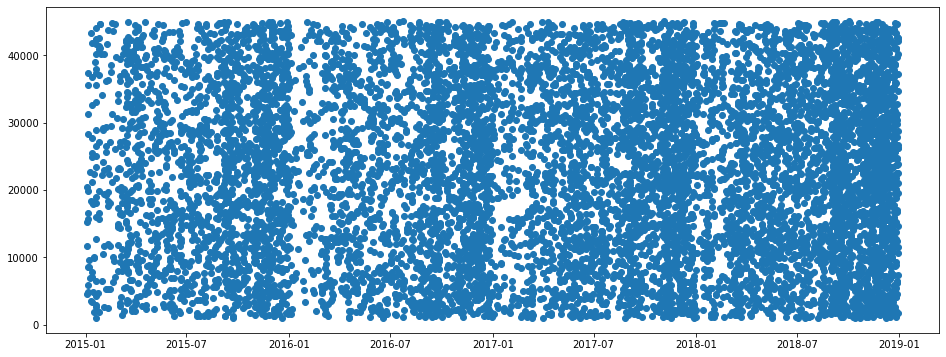

In [22]:
plt.figure(figsize=(16,6))
plt.scatter(x=df['Order_Date'], y=df['Sales'])

### Можно предположить, что есть сезонность

### Построим, как меняются продажи по месяцам в разные годы

In [23]:
df['Year'] = df['Order_Date'].dt.year
df['Month'] = df['Order_Date'].dt.month

In [24]:
monthly_sales = df.groupby(['Year', 'Month'])['Sales'].mean().reset_index()

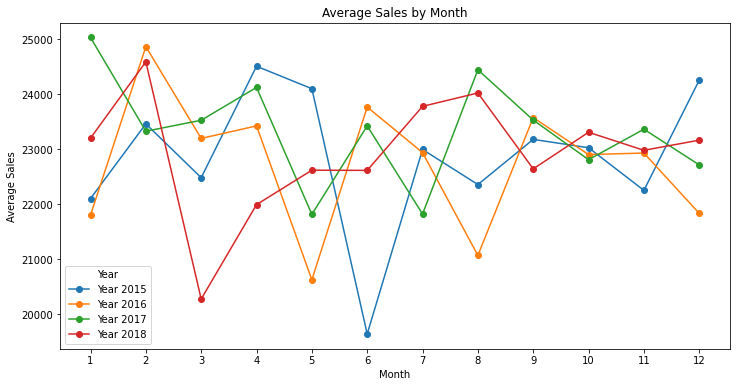

In [25]:
plt.figure(figsize=(12, 6))

for year in monthly_sales['Year'].unique():
    yearly_data = monthly_sales[monthly_sales['Year'] == year]
    plt.plot(yearly_data['Month'], yearly_data['Sales'], marker='o', label=f'Year {year}')

plt.title('Average Sales by Month')
plt.xlabel('Month')
plt.ylabel('Average Sales')
plt.xticks(range(1, 13))  
plt.legend(title='Year')
plt.show()

### Посмотрим на средние значения продаж по месяцам для разных категорий

In [26]:
monthly_sales_by_category = df.groupby(['Month', 'Sub_Category'])['Sales'].mean().reset_index()
unique_categories = monthly_sales_by_category['Sub_Category'].unique()

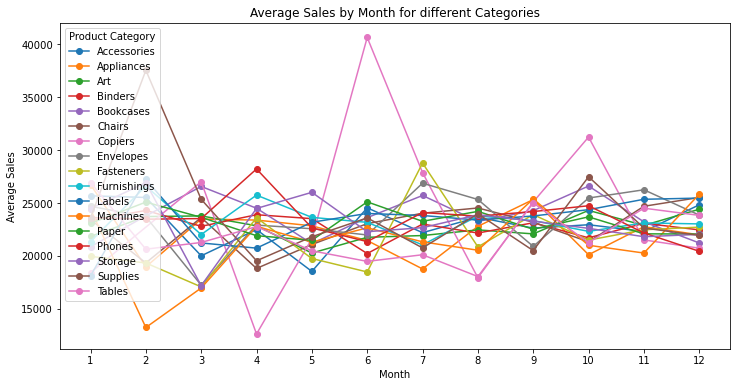

In [27]:
plt.figure(figsize=(12, 6))

for category in unique_categories:
    df_category = monthly_sales_by_category[monthly_sales_by_category['Sub_Category'] == category]
    plt.plot(df_category['Month'], df_category['Sales'], marker='o', label=category)

plt.title('Average Sales by Month for different Categories')
plt.xlabel('Month')
plt.ylabel('Average Sales')
plt.xticks(range(1, 13))  # Месяцы от 1 до 12
plt.legend(title='Product Category')
plt.show()

### У Phones,Tables или Appliances есть явные всплески в определённые месяцы, что может быть связано с сезонными скидками или праздничными периодами

### Возможные причины сезонности:
#### Техника : продажи могут увеличиваться ближе к концу года из-за праздничных распродаж
#### Канцелярия: такие товары могут приобретаться перед началом учебного года

#  Построить boxplot («Ящик с усами») на основе продаж (Sales). Найти мажоритарную черту (т.е. избавиться от аномалий и представить четкую картину распределения величин).

### Построим boxplot, чтобы посмотреть на распределение и основные статистики

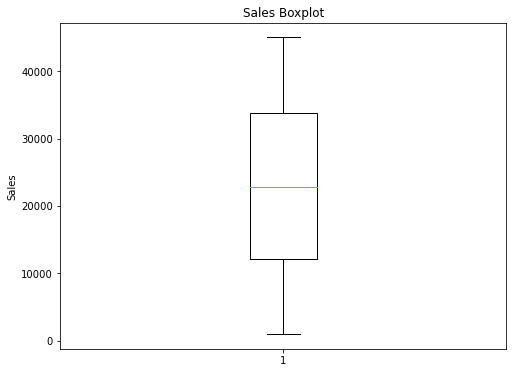

In [28]:
plt.figure(figsize=(8, 6))
plt.boxplot(x=df['Sales'])
plt.title('Sales Boxplot')
plt.ylabel('Sales')
plt.show()

### Boxplot не показал никаких выбросов, медиана совпадает с средним.
### Можно предположить, что данные распределены симметрично относительно медианы. Это дает представление о том, что большая часть данных сконцентрирована в центральной части распределения.

### Посмотрим межквартильный размах 

In [29]:
Q1 = df['Sales'].quantile(0.25)
Q3 = df['Sales'].quantile(0.75)
IQR = Q3 - Q1

lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR

outliers = df[(df['Sales'] < lower) | (df['Sales'] > upper)]
print("Выбросы:")
print(outliers)

Выбросы:
Empty DataFrame
Columns: [ID, Order_Date, Class, Region, Sub_Category, Sales, Year, Month]
Index: []


### Посмотрим на расстояние между минимальным и максимальным значениями и нашим боксом

In [30]:
min_value = df['Sales'].min()
max_value = df['Sales'].max()

distance_Q1_min = Q1 - min_value
distance_Q3_max = max_value - Q3

print(f"Расстояние от Q1 до минимального значения: {distance_Q1_min}")
print(f"Расстояние от Q3 до максимального значения: {distance_Q3_max}")

Расстояние от Q1 до минимального значения: 11132.831
Расстояние от Q3 до максимального значения: 11265.280000000006



### Посмотрим меньшие квантили

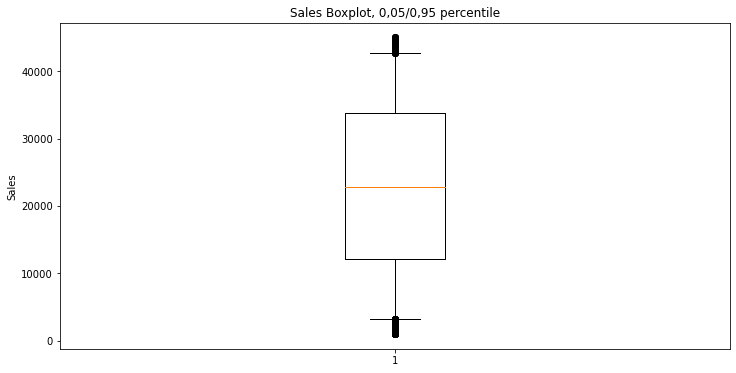

In [31]:
plt.figure(figsize=(12,6))

plt.boxplot(x=df['Sales'], whis=[5,95])

plt.title('Sales Boxplot, 0,05/0,95 percentile')
plt.ylabel('Sales')
plt.show()

### 0,05 и 0,95 перцентили показали, что есть выбросы, которые не попадают в основной диапазон значений. Посмотрим на плотность распределения наших данных при помощи KDE

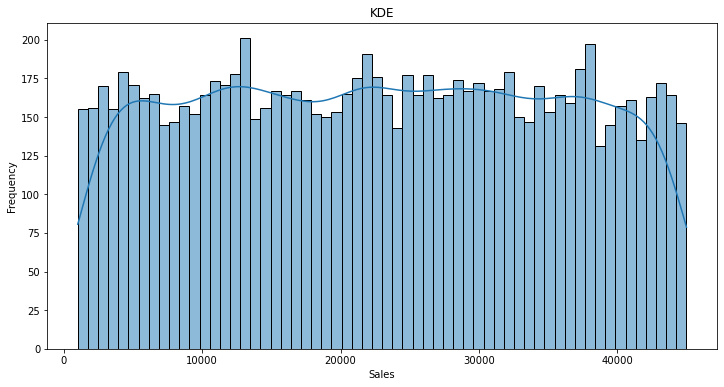

In [32]:
plt.figure(figsize=(12, 6))
sns.histplot(df['Sales'], kde=True, bins=60)
plt.title('KDE')
plt.xlabel('Sales')
plt.ylabel('Frequency')
plt.show()

In [33]:
p5 = df['Sales'].quantile(0.05)
p95 = df['Sales'].quantile(0.95)

outliers = df[(df['Sales'] < p5) | (df['Sales'] > p95)]

len(outliers)

980

### Мы нашли 980 выбросов. Избавимся от них

In [34]:
df.shape

(9800, 8)

In [35]:
df_cleaned = df[(df['Sales'] >= p5) & (df['Sales'] <= p95)]
df_cleaned.shape

(8820, 8)

### Построим ещё один boxplot, но уже на очищенных данных

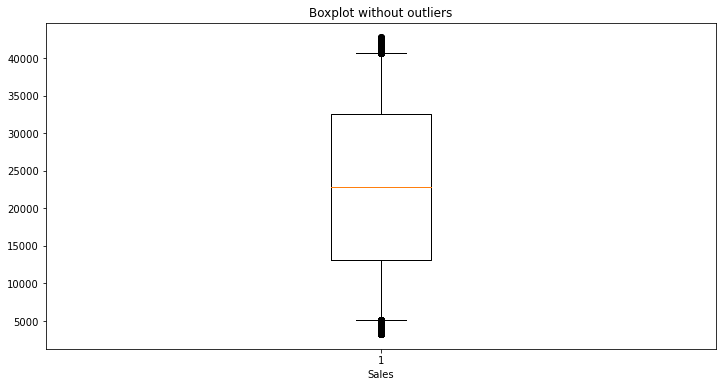

In [36]:
plt.figure(figsize=(12, 6))

plt.boxplot(x=df_cleaned['Sales'], whis=[5,95])

plt.title('Boxplot without outliers')
plt.xlabel('Sales')
plt.show()

In [37]:
p5 = df_cleaned['Sales'].quantile(0.05)
p95 = df_cleaned['Sales'].quantile(0.95)

outliers = df_cleaned[(df_cleaned['Sales'] < p5) | (df_cleaned['Sales'] > p95)]

len(outliers)

882

### Можно заметить, что всё равно остались выбросы.
#### Возможно это происходит потому что есть некая сезонность -> выбросы являются частью данных

# Для этого задания необходимо разбить все покупки на энное количество групп “Sale_group” (Допустим маленькие продажи, средние и высокие) на основе Sales. Сгруппировать данные на основе региона и группы продаж (Region, Sale_group). Определить основные тенденции и паттерны. Выделить наиболее «прибыльную» группу.


In [38]:
df_cleaned['Sale_group'] = pd.qcut(df_cleaned['Sales'], q=3, labels=['Low Sales', 'Medium Sales', 'High Sales'])

C:\Users\zxc\AppData\Local\Temp/ipykernel_28660/3338868900.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['Sale_group'] = pd.qcut(df_cleaned['Sales'], q=3, labels=['Low Sales', 'Medium Sales', 'High Sales'])


In [39]:
grouped_qcut = df_cleaned.groupby(['Region', 'Sale_group'])['Sales'].agg(['count', 'mean', 'sum']).reset_index()
grouped_qcut.sort_values(by='Sale_group', inplace=True)
grouped_qcut

,Region,Sale_group,count,mean,sum
0,Владивосток,Low Sales,847,9803.464421,8.303534e+06
3,Калиниград,Low Sales,943,9968.194396,9.400007e+06
6,Москва,Low Sales,465,9624.167985,4.475238e+06
9,Урал,Low Sales,685,9869.061420,6.760307e+06
1,Владивосток,Medium Sales,787,22997.016734,1.809865e+07
4,Калиниград,Medium Sales,985,23016.697482,2.267145e+07
7,Москва,Medium Sales,487,22851.175749,1.112852e+07
10,Урал,Medium Sales,681,22828.046079,1.554590e+07
2,Владивосток,High Sales,846,35825.735804,3.030857e+07
5,Калиниград,High Sales,918,36103.269303,3.314280e+07


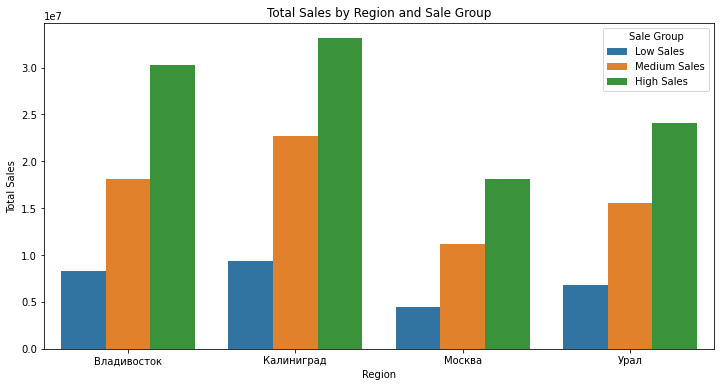

In [40]:
plt.figure(figsize=(12, 6))
sns.barplot(data=grouped_qcut, x='Region', y='sum', hue='Sale_group')

plt.title('Total Sales by Region and Sale Group')
plt.xlabel('Region')
plt.ylabel('Total Sales')
plt.legend(title='Sale Group')
plt.show()

## Наиболее прибыльная группа - High Sales

### Можно выделить следующие тенденции:

#### Регионы различаются по уровню продаж
#### Группа "High Sales" вносит наибольший вклад в общую прибыль
#### Группа "Medium Sales" поддерживает стабильный средний вклад
#### "Low Sales" имеет наибольшее количество транзакций, но самый маленький вклад в общую прибыль